# Cognitive Computing (BIA 662)

# Instructor: Dr. Christopher Asakaweiscz

# Students: Caitlyn Garder, Yina Dong and Abhitej Kodali

###### Reference: https://www.kaggle.com/shivamb/a-hybrid-approach-to-connect-donors-to-projects

### Data Preparation

In [1]:
# keras modules 
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import Embedding, Reshape, Dropout, Dense, Input, Concatenate
from keras.models import Sequential, Model

# sklearn modules 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.cluster import KMeans 
from sklearn import preprocessing 
import matplotlib.pyplot as plt

# other python utilities 
from collections import Counter 
from tqdm import tqdm 
import pandas as pd 
import numpy as np 
import warnings, math, gc

from IPython.core.display import display, HTML, Javascript
import IPython.display
import json

# ignore the warnings 
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
path = "E:/Cognitive Computing BIA662/Project/io/"
donors_df = pd.read_csv(path+"Donors.csv")
donations_df = pd.read_csv(path+"Donations.csv")
schools_df = pd.read_csv(path+"Schools.csv")
projects_df = pd.read_csv(path+"Projects.csv")

In [3]:
donation_donor = donations_df.merge(donors_df, on='Donor ID', how='inner')

## Merge projects and schools 
projects_df = projects_df.merge(schools_df, on='School ID', how='inner')

## Create some additional features in projects data
projects_df['cost'] = projects_df['Project Cost'].apply(lambda x : float(str(x).replace("$","").replace(",","")))
projects_df['Posted Date'] = pd.to_datetime(projects_df['Project Posted Date'])
projects_df['Posted Year'] = projects_df['Posted Date'].dt.year
projects_df['Posted Month'] = projects_df['Posted Date'].dt.month

## Merge projects and donations (and donors)
master_df = projects_df.merge(donation_donor, on='Project ID', how='inner')

## Delete unusued datasets and clear the memory
del donation_donor, schools_df
gc.collect()

106

In [4]:
## Create a smaller version of data so that it runs on kaggle kernel
## keep only fully funded projects
projects_mini = projects_df[projects_df['Project Current Status'] == "Fully Funded"]

## Set rows = -1 to run on complete dataset, To run in kaggle kernel, I am setting to a smaller number 
rows = 5000

## keep only the projects of 2017, quarter 3, take small sample, (so that it runs on kaggle kernels)
if rows != -1:
    projects_mini = projects_mini[(projects_mini['Posted Year'] == 2017) &
                                  (projects_mini['Posted Month'] > 9)]
    projects_mini = projects_mini.reset_index()[:rows]

## replace the missing values and obtain project essay values 
projects_mini['Project Essay'] = projects_mini['Project Essay'].fillna(" ")
xtrain = projects_mini['Project Essay'].values

### Including Word Vectorizer 

In [5]:
EMBEDDING_FILE = 'E:/Cognitive Computing BIA662/Project/crawl-300d-2M.vec'

embeddings_index = {}
f = open(EMBEDDING_FILE, encoding="utf8")
count = 0
for line in tqdm(f):
    count += 1
    ## Remove this if condition to read 2M rows 
    if count == 500000: 
        break
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

499388it [02:40, 6096.52it/s]

In [6]:
def generate_doc_vectors(s):
    words = str(s).lower().split() 
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        if w in embeddings_index:
            M.append(embeddings_index[w])
    v = np.array(M).sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

xtrain_embeddings = [generate_doc_vectors(x) for x in tqdm(xtrain)]

del xtrain
gc.collect()


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1145.40it/s]

9

In [7]:
scl = preprocessing.StandardScaler()
xtrain_embeddings = np.array(xtrain_embeddings)
xtrain_embeddings = scl.fit_transform(xtrain_embeddings)

In [8]:
projects_mini[['Project ID', 'Project Title', 'Project Subject Category Tree', 'Project Resource Category', 'Project Cost']].head()

,Project ID,Project Title,Project Subject Category Tree,Project Resource Category,Project Cost
0,83b4f3fbe743cb12ae2be7347ef03ecb,Learning Through Art,Music & The Arts,Computers & Tablets,1337.05
1,a0446d393feaadbeb32cd5c3b2b36d45,Food To Refuel Learning,"Applied Learning, Health & Sports","Food, Clothing & Hygiene",320.81
2,f5282976f549f8d50f5aa9d715245272,Empowering Creative Artists in TK,Music & The Arts,Art Supplies,533.61
3,d20ec20b8e4de165476dfd0a68da0072,Mini Minds Need iPad Minis,"Literacy & Language, Math & Science",Computers & Tablets,1076.68
4,ef58d9361dbd82495c4d59ea31b50c58,Pencil Me In Please,Music & The Arts,Art Supplies,372.56


In [9]:
print ("Project ID: " + projects_mini['Project ID'].iloc(0)[0])
print ("Project Vector: ")
print (xtrain_embeddings)

Project ID: 83b4f3fbe743cb12ae2be7347ef03ecb
Project Vector: 
[[ 0.37545836 -0.30674359  1.51354277 ..., -0.75308675  1.0189513
  -0.73080039]
 [ 0.67033547 -1.64864933 -1.54137528 ..., -0.99949265  1.17705214
  -1.2799139 ]
 [ 0.45189461  0.46249142  0.93241483 ...,  0.05061078  0.34672359
  -0.45830959]
 ..., 
 [ 1.00016046 -1.01591504  1.71333385 ..., -1.56487608 -0.7655043
   1.01479721]
 [ 0.51075649 -0.8271969  -0.16872838 ..., -1.12879014 -0.67229325
   0.62636101]
 [ 0.59072489  0.91908222 -0.69052368 ...,  0.90551746  0.77423191
  -0.69751859]]


### Subsetting the data

In [10]:
# slicing the users dataset so that it runs in kaggle kernel memory 
users = master_df[(master_df['Donor Is Teacher'] == 'No') & 
                  (master_df['Donor State'] == 'Texas') & 
                  (master_df['Posted Year'] == 2017)].reset_index()

users1 = users[:1000]
del master_df
gc.collect()

499388it [25:27, 6096.52it/s]

14

### Including Zipcode level data to create graph network

In [11]:
## load the external dataset
external_context = pd.read_csv('E:/Cognitive Computing BIA662/Project/scraped_results.csv', na_values=0, dtype={'zipcode':str})
external_context = external_context[(external_context['Housing Units']>0) | (external_context['Land Area']>0)]
external_context = external_context.fillna(0)
features = list(set(external_context.columns) - set(['id', 'zipcode']))
agg_doc = {}
for feat in features:
    agg_doc[feat] = 'mean'

area_context = external_context.groupby('id').agg(agg_doc).reset_index().rename(columns = {'id' : 'Donor Zip'})
area_context = area_context[area_context['Housing Units'] != 0]
area_context.head()

,Donor Zip,Median Home Value,Occupied Housing Units,Land Area,Population,Median Household Income,Population Density,Water Area,Housing Units
0,602,0.0,15002.0,30.61,41520.0,0.0,1356.0,1.72,18073.0
1,603,0.0,21161.0,31.61,54689.0,0.0,1730.0,0.07,25653.0
2,606,0.0,2404.0,42.31,6615.0,0.0,156.0,0.00,2877.0
3,610,0.0,10836.0,35.92,29016.0,0.0,808.0,1.61,12618.0
4,612,0.0,26038.0,67.61,67010.0,0.0,991.0,3.79,30992.0


### Applying K-means Clustering to create different groups

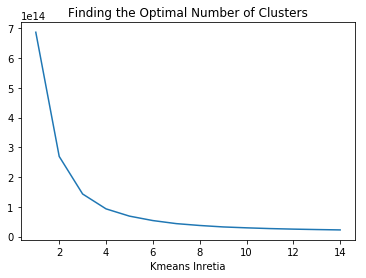

In [12]:
features = list(set(area_context.columns) - set(['Donor Zip']))
inretia = []
for i in range(1,15):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(area_context[features])
    inretia.append(kmeans.inertia_)
plt.plot(range(1,15),inretia)
plt.title('Finding the Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.xlabel('Kmeans Inretia')
plt.show()

In [13]:
# apply kmeans clustering 
kmeans = KMeans(n_clusters=8, init='k-means++', max_iter=300, n_init=10, random_state=0) 
area_context['area_context_cluster'] = kmeans.fit_predict(area_context[features])

# merge with the donors data
users1['Donor Zip'] = users1['Donor Zip'].astype(str)
area_context['Donor Zip'] = area_context['Donor Zip'].astype(str)

users1 = users1.merge(area_context[['Donor Zip', 'area_context_cluster']], on="Donor Zip", how="left")
area_context[['Donor Zip', 'area_context_cluster']].head(10)

,Donor Zip,area_context_cluster
0,602,7
1,603,7
2,606,7
3,610,7
4,612,7
5,616,7
6,617,7
7,622,7
8,623,7
9,627,7


In [14]:
users1['Project Essay'] = users1['Project Essay'].fillna(" ")
utrain = users1['Project Essay'].values

utrain_embeddings = [generate_doc_vectors(x) for x in tqdm(utrain)]
utrain_embeddings = np.array(utrain_embeddings)
utrain_embeddings = scl.fit_transform(utrain_embeddings)

del utrain
gc.collect()


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 28.15it/s]

30

In [15]:
users1['Project Type'] = users1['Project Type'].fillna("Teacher Led")
users1['Project Subject Category Tree'] = users1['Project Subject Category Tree'].fillna(" ")
users1['area_context_cluster'] = users1['area_context_cluster'].astype(str)

## aggregate the donors and their past donations in order to create their donor - profiles
user_profile = users1.groupby('Donor ID').agg({'Donation Amount' : ['min', 'max', 'mean', 'median'],
                                               'cost' : ['min', 'max', 'mean', 'median'], 
                                      'Project Subject Category Tree' : lambda x: ", ".join(x), 
                                      'Project ID' : lambda x: ",".join(x), 
                                      'School Metro Type' : lambda x: ",".join(x), 
                                      'Project Title' : lambda x: ",".join(x), 
                                      'area_context_cluster' : lambda x: ",".join(x), 
                                      'School Percentage Free Lunch' : 'mean',
                                      'Project Grade Level Category' : lambda x : ",".join(x),
                                      'Project Type' : 'count'}
                                    ).reset_index().rename(columns={'Project Type' : "Projects Funded"})


In [16]:
## flatten the features of every donor

def get_map_features(long_text):
    a = long_text.split(",")
    a = [_.strip() for _ in a]
    mapp = dict(Counter(a))
    return mapp
    
user_profile['Category_Map'] = user_profile['Project Subject Category Tree']['<lambda>'].apply(get_map_features)
user_profile['Projects_Funded'] = user_profile['Project ID']['<lambda>'].apply(get_map_features)
user_profile['GradeLevel_Map'] = user_profile['Project Grade Level Category']['<lambda>'].apply(get_map_features)
user_profile['AreaContext_Map'] = user_profile['area_context_cluster']['<lambda>'].apply(get_map_features)
user_profile['SchoolMetroType_Map'] = user_profile['School Metro Type']['<lambda>'].apply(get_map_features)
user_profile = user_profile.drop(['Project Grade Level Category', 'Project Subject Category Tree',  'School Metro Type', 'Project ID', 'area_context_cluster'], axis=1)

user_profile.head()

Donor ID Donation Amount                          \
                                                min     max    mean  median   
0  00afcce0340bff7aa6c2fa3ebdb27e97           80.87   80.87   80.87   80.87   
1  00b3c149822c79e4fca9be0bea5c900c          100.00  100.00  100.00  100.00   
2  0133e739201bcbac044aefe9a73ac8e1           25.00   25.00   25.00   25.00   
3  0266bb37ba485d6b1c5868499a3d71a9           35.00   35.00   35.00   35.00   
4  026db11833e9fda9487fd59c1da4d51d           20.00   20.00   20.00   20.00   

     cost                                                     Project Title  \
      min     max    mean  median                                  <lambda>   
0  391.15  391.15  391.15  391.15                     Make Room for Science   
1  883.60  883.60  883.60  883.60  Today a Reader, Tomorrow a Leader! -ATPE   
2  509.33  509.33  509.33  509.33                      Projecting to Learn!   
3  210.91  210.91  210.91  210.91          My Turn, Your Turn!  Let's Play!   
4  883.60  883.60  883.60  883.60                  Reading at Home is Fun!    

  School Percentage Free Lunch Projects Funded  \
                          mean           count   
0                         65.0               1   
1                         33.0               1   
2                         68.0               1   
3                         80.0               1   
4                         33.0               1   

                                     Category_Map  \
                                                    
0                           {'Math & Science': 1}   
1                      {'Literacy & Language': 1}   
2                      {'Literacy & Language': 1}   
3  {'Literacy & Language': 1, 'Special Needs': 1}   
4                      {'Literacy & Language': 1}   

                           Projects_Funded        GradeLevel_Map  \
                                                                   
0  {'091af883d7a09fa20e5f2d78b21a5e1e': 1}     {'Grades 6-8': 1}   
1  {'e00c9b127a68f337c9df109ec958434c': 1}  {'Grades PreK-2': 1}   
2  {'b1aec142605ec04a9edbe5ba6f5fda9b': 1}     {'Grades 6-8': 1}   
3  {'e1838f47bd4b73b8eb3e7b1d6a138025': 1}     {'Grades 3-5': 1}   
4  {'1de158aeccf4e353d19d32a480e04c62': 1}  {'Grades PreK-2': 1}   

  AreaContext_Map SchoolMetroType_Map  
                                       
0      {'nan': 1}        {'urban': 1}  
1      {'7.0': 1}        {'urban': 1}  
2      {'nan': 1}        {'urban': 1}  
3      {'7.0': 1}        {'rural': 1}  
4      {'nan': 1}        {'urban': 1}

In [17]:
def get_average_vector(project_ids):
    ids = list(project_ids.keys())
    
    donor_proj_vec = []
    for idd in ids:        
        unique_proj_ids = users1[users1['Project ID'] == idd].index.tolist()[0]
        donor_proj_vec.append(utrain_embeddings[unique_proj_ids])
    proj_vec = np.array(donor_proj_vec).mean(axis=0)
    return proj_vec 

user_profile['project_vectors'] = user_profile['Projects_Funded'].apply(lambda x : get_average_vector(x))
user_profile[['Donor ID', 'project_vectors']].head(10)

,Donor ID,project_vectors
,,
0,00afcce0340bff7aa6c2fa3ebdb27e97,"[0.316774, -0.604226, -0.153483, -0.336125, 0...."
1,00b3c149822c79e4fca9be0bea5c900c,"[0.33297, -1.12515, -0.93811, 0.359807, -0.281..."
2,0133e739201bcbac044aefe9a73ac8e1,"[-2.11002, 0.194232, -0.32664, -2.5605, 1.0252..."
3,0266bb37ba485d6b1c5868499a3d71a9,"[-0.0791564, 0.346862, 0.923297, -1.16228, 0.7..."
4,026db11833e9fda9487fd59c1da4d51d,"[0.229175, -0.843705, -1.16575, 0.894804, -0.3..."
5,02d505256a811b5e8e9c5ecab041f7da,"[-0.842603, 1.44, -0.294377, 0.400872, -0.0060..."
6,04214ec8526c0555c47135e5254a8c5a,"[0.452189, -0.477629, -0.840049, 0.79877, -0.1..."
7,047dcf5cefaf2e57ebbd743e49adc7de,"[0.77606, 0.952072, 2.02095, 0.21339, 1.82387,..."
8,06f51e9498bdae8683fbaeadfac44f42,"[0.869504, 0.701352, -1.21733, -1.12534, -1.58..."


In [18]:
# compute the project interactions 
project_interactions = linear_kernel(xtrain_embeddings, xtrain_embeddings)

In [19]:
# create the edges of one node with other most similar nodes  
project_edges = {}
for idx, row in projects_mini.iterrows():
    similar_indices = project_interactions[idx].argsort()[:-100:-1]
    similar_items = [(project_interactions[idx][i], projects_mini['Project ID'][i]) for i in similar_indices]
    project_edges[row['Project ID']] = similar_items[:20]

In [20]:
def get_project(id):
    return projects_mini.loc[projects_mini['Project ID'] == id]['Project Title'].tolist()[0]

def similar_projects(project_id, num):
    print("Project: " + get_project(project_id))
    print("")
    print("Similar Projects: ")
    print("")
    recs = project_edges[project_id][1:num]
    for rec in recs:
        print(get_project(rec[1]) + " (score:" + str(rec[0]) + ")")

In [21]:
similar_projects(project_id="a0446d393feaadbeb32cd5c3b2b36d45", num=10)

Project: Food To Refuel Learning 

Similar Projects: 

Quill to the Rescue...  We Need Snacks! (score:215.974)
Yummy, Yummy I Have Breakfast In My Tummy! (score:189.278)
Healthy Snacks for 2nd Graders (score:176.321)
Yummy in My Tummy (score:175.209)
Snacks & Supplies for Super Students! (score:166.738)
Juice Boxes for PreK (score:165.305)
Healthy Snacks for Kinders  (score:158.309)
Snacks for Hungry Students! Part 2 (score:148.422)
Healthy Breakfast = Happy Students Ready to Learn  (score:147.599)


In [22]:
similar_projects(project_id="83b4f3fbe743cb12ae2be7347ef03ecb", num=10)

Project: Learning Through Art

Similar Projects: 

Learning Through Art (score:185.99)
Art & Crafts Materials for PreK (score:151.441)
The Power of Community....Telling Our Stories through Mural Painting (score:137.964)
Drawing Skills for Keeps (score:136.819)
Dynamic Drawing Studio (score:127.557)
Traditional Darkroom Printing Portfolio Development (score:127.158)
Sketchbook Awaken (score:125.581)
Artistic Vision: Starting with a Blank Sheet of Paper (score:122.097)
Quaver! Music That's Seriously Fun and Then Some (score:120.487)


In [23]:
user_embeddings = user_profile['project_vectors'].values

user_embeddings_matrix = np.zeros(shape=(user_embeddings.shape[0], 300))
for i,embedding in enumerate(user_embeddings):
    user_embeddings_matrix[i] = embedding

donors_interactions = linear_kernel(user_embeddings_matrix, user_embeddings_matrix)

In [24]:
user_edges = {}
for idx, row in user_profile.iterrows():
    similar_indices = donors_interactions[idx].argsort()[:-10:-1]

    similar_items = [(float(donors_interactions[idx][i]), list(user_profile['Donor ID'])[i]) for i in similar_indices]
    user_edges[row['Donor ID'][0]] = similar_items[1:]

In [25]:
def get_donor(id):
    return user_profile.loc[user_profile['Donor ID'] == id]['Donor ID'].tolist()[0]

def similar_users(donor_id, num):
    print("Donor: " + get_donor(donor_id))
    print ("Projects: " + str(user_profile[user_profile['Donor ID'] == donor_id]['Project Title']['<lambda>'].iloc(0)[0]))

    print("")
    print("Similar Donors: ")
    print("")    
    recs = user_edges[donor_id][:num]
    for rec in recs:
        print("DonorID: " + get_donor(rec[1]) +" | Score: "+ str(rec[0]) )
        print ("Projects: " + str(user_profile[user_profile['Donor ID'] == rec[1]]['Project Title']['<lambda>'].iloc(0)[0]))
        print   ("")

In [26]:
similar_users(donor_id="fee882faa77bc6691bd24d4d5abd5733", num=5)

Donor: fee882faa77bc6691bd24d4d5abd5733
Projects: Take "Pride" In Reading,Classroom Basics!,Wicked Supplies for Good Students,Native American Book Project

Similar Donors: 

DonorID: 7eb38df095e62cf2edac5db90227b4bb | Score: 199.56586601179208
Projects: Native American Book Project

DonorID: 7947eeed75e2a468692cf6f5737de5b8 | Score: 187.029116226539
Projects: I Know the Arabic Word, but What About English?

DonorID: b444c865e05512f9b2d4d716ab9ef271 | Score: 155.6150347311654
Projects: Diverse Books for Dynamic Students

DonorID: 27b2c651d7c1bd524186d4f5f8c18de7 | Score: 152.95787437046965
Projects: Learn Colorfully With a New Printer!

DonorID: 77e48f420bcd41f60c7924fb2aa11c40 | Score: 138.65267469291592
Projects: Slaughterhouse-Five, or The Children's Crusade: A Duty-Dance with Death



In [27]:
similar_users(donor_id="d52242e9d5006fb97fcdb5565982f0ad", num=5)

Donor: d52242e9d5006fb97fcdb5565982f0ad
Projects: Building Up Our Shelf-Esteem ,Building Up Our Shelf-Esteem 

Similar Donors: 

DonorID: 92c684d0851cadba126c3cf01252083f | Score: 98.862497484937
Projects: We Got 99 Problems and Math is One 

DonorID: 3f9299ac48ff3a4bd1c2a61ee66190ff | Score: 94.42830223025989
Projects: Spilling Ink for Classroom Scribes

DonorID: e270370a22d9929ec84dfd7eeb9b7eb4 | Score: 85.93867805492988
Projects: We Like Buddy Books and We Cannot Lie

DonorID: ce82394cd7f7e53e00b95c79b3df5aa5 | Score: 85.88535358163026
Projects: For the Love of Reading!

DonorID: bb5c7f463c8c2439c83cf13af51c659f | Score: 84.07827947620237
Projects: Books Forever!



### Creating Graph Network

In [28]:
class DonorsGraph():
    """
    Class to create the graph for donors and save their information in different nodes.
    """
    
    
    def __init__(self, graph_name):
        self.graph = {}
        self.graph_name = graph_name
    
    # function to add new nodes in the graph
    def _create_node(self, node_id, node_properties):
        self.graph[node_id] = node_properties 
    
    # function to view the nodes in the graph
    def _view_nodes(self):
        return self.graph
    
    # function to create edges
    def _create_edges(self, node_id, node_edges):
        if node_id in self.graph:
            self.graph[node_id]['edges'] = node_edges

In [29]:
## initialize the donors graph
dg = DonorsGraph(graph_name = 'donor')

## iterate in donor profiles and add the nodes
for idx, row in user_profile.iterrows():
    node_id = row['Donor ID'].tolist()[0]
    node_properties = dict(row)
    dg._create_node(node_id, node_properties)

In [30]:
node = dg._view_nodes()['12d74c3cd5f21ed4b17c781da828d076']
node[('project_vectors','')][0:50]

array([-0.1860429 ,  0.79038966,  0.15713227, -1.15713072,  1.34679651,
        0.29486755,  1.02634895,  2.2459662 ,  0.51848143,  0.62296623,
        1.2353735 , -1.12998712,  0.54590881, -1.62258315, -0.44540197,
       -0.92671424,  2.05297565,  0.04276206,  0.11360244,  1.78012383,
        0.7323128 ,  1.71653259,  0.01683064,  0.87949997,  1.44221246,
        0.55377924, -0.85902017,  0.98986596, -0.54773211,  0.17703311,
       -1.00802565, -0.91169202,  0.48391846, -1.16662908, -0.80172038,
        1.01969659, -1.34233487,  2.88672018,  0.44174263,  0.94130898,
        1.00310421,  0.31490216, -0.97372842, -0.3618488 ,  0.36439693,
       -0.0621463 , -1.45483136,  1.86792707,  1.05366814, -0.20090011], dtype=float32)

In [31]:
del node[('project_vectors','')]
node

{('Donor ID', ''): '12d74c3cd5f21ed4b17c781da828d076',
 ('Donation Amount', 'min'): 15.0,
 ('Donation Amount', 'max'): 15.0,
 ('Donation Amount', 'mean'): 15.0,
 ('Donation Amount', 'median'): 15.0,
 ('cost', 'min'): 607.06,
 ('cost', 'max'): 607.06,
 ('cost', 'mean'): 607.06,
 ('cost', 'median'): 607.06,
 ('Project Title', '<lambda>'): 'My Projects Have Sound...Whoa!',
 ('School Percentage Free Lunch', 'mean'): 83.0,
 ('Projects Funded', 'count'): 1,
 ('Category_Map', ''): {'Math & Science': 1, 'Special Needs': 1},
 ('Projects_Funded', ''): {'809ad7108b5e10a5992c27c8cf381b97': 1},
 ('GradeLevel_Map', ''): {'Grades 6-8': 1},
 ('AreaContext_Map', ''): {'7.0': 1},
 ('SchoolMetroType_Map', ''): {'suburban': 1}}

In [32]:
def get_donor(id):
    return user_profile.loc[user_profile['Donor ID'] == id]['Donor ID'].tolist()[0]

def get_similar_donors(donor_id, num):
    # improve this algorithm - > currently only text, add other features as well 
    recs = user_edges[donor_id][:num]    
    return recs 

for idx, row in user_profile.iterrows():
    node_id = row['Donor ID'].tolist()[0]
    node_edges = get_similar_donors(donor_id=node_id, num=5)
    dg._create_edges(node_id, node_edges)

In [33]:
dg._view_nodes()['00b3c149822c79e4fca9be0bea5c900c']['edges']

[(235.69163859697935, '18269b36d87bf556790764c47c87fb44'),
 (235.69163859697935, 'f976336c74a4c858da48c10baa5334fb'),
 (235.69163859697935, 'f1503c67aaa91529f2f52456290961f5'),
 (235.69163859697935, '2fce06fec6d112f655374592b70f416e'),
 (235.69163859697935, 'de0c7515daee63903bcf661da3715344')]

In [34]:
class ProjectsGraph():
    def __init__(self, graph_name):
        self.graph = {}
        self.graph_name = graph_name
        
    def _create_node(self, node_id, node_properties):
        self.graph[node_id] = node_properties 
    
    def _view_nodes(self):
        return self.graph
    
    def _create_edges(self, node_id, node_edges):
        if node_id in self.graph:
            self.graph[node_id]['edges'] = node_edges

In [35]:
pg = ProjectsGraph(graph_name = 'projects')

for idx, row in projects_mini.iterrows():
    node_id = row['Project ID']
    node_properties = dict(row)
    del node_properties['Project Essay']
    del node_properties['Project Need Statement'] 
    del node_properties['Project Short Description']
    pg._create_node(node_id, node_properties)

In [36]:
pg._view_nodes()['83b4f3fbe743cb12ae2be7347ef03ecb']

{'index': 213,
 'Project ID': '83b4f3fbe743cb12ae2be7347ef03ecb',
 'School ID': 'e180c7424cb9c68cb49f141b092a988f',
 'Teacher ID': '434725d4850d3876e07e79d91de86073',
 'Teacher Project Posted Sequence': 19,
 'Project Type': 'Teacher-Led',
 'Project Title': 'Learning Through Art',
 'Project Subject Category Tree': 'Music & The Arts',
 'Project Subject Subcategory Tree': 'Visual Arts',
 'Project Grade Level Category': 'Grades PreK-2',
 'Project Resource Category': 'Computers & Tablets',
 'Project Cost': 1337.05,
 'Project Posted Date': '2017-11-11',
 'Project Expiration Date': '2018-03-10',
 'Project Current Status': 'Fully Funded',
 'Project Fully Funded Date': '2018-01-25',
 'School Name': 'Stanford Primary Center',
 'School Metro Type': 'suburban',
 'School Percentage Free Lunch': 95.0,
 'School State': 'California',
 'School Zip': 90280,
 'School City': 'South Gate',
 'School County': 'Los Angeles',
 'School District': 'Los Angeles Unif Sch Dist',
 'cost': 1337.05,
 'Posted Date': Ti

In [37]:
def get_similar_projects(project_id, num):
    recs = project_edges[project_id][:num]
    return recs 

for idx, row in projects_mini.iterrows():
    node_id = row['Project ID']
    node_edges = get_similar_projects(project_id=node_id, num=5)
    pg._create_edges(node_id, node_edges)

In [38]:
pg._view_nodes()['83b4f3fbe743cb12ae2be7347ef03ecb']['edges']

[(208.97978, '3da8b3402269d1e98950f7073976f6cd'),
 (185.98973, '83b4f3fbe743cb12ae2be7347ef03ecb'),
 (151.44121, '7a3e441f66899838a20e3c92b74b8aca'),
 (137.96387, 'e5aa6701085ff6e4cc19fa8f2753cd8b'),
 (136.81871, '6c0db98d7e4bc5c253233501f4829145')]

In [39]:
nodes = []
links = []

nodes.append({'id' : 'Donors', 'group' : 2, 'size' : 20 })
for key, val in list(dg._view_nodes().items())[:50]:
    if len(val['edges']) == 0:
        continue
    nodes.append({'id' : key, 'group' : 2, 'size' : 15})
    links.append({"source" : "Donors", "target" : key, "value" : 10})
    
    for node in val['edges']:
        nodes.append({'id' : node[1], 'group' : 2, 'size' : 12})
        
        sv = np.log(node[0])
        ew = 10
        if sv > 6:
            ew = 100
        elif sv > 5:
            ew = 20
        elif sv > 4:
            ew = 15
        else:
            ew = 10
                    
        links.append({"source": key, "target": node[1], "value": ew})
doc = {'nodes' : nodes, 'links' : links}
with open("donorg.json", "w") as fout:
    fout.write(json.dumps(doc))
    
    

nodes = []
links = []
nodes.append({'id' : 'Projects', 'group' : 0, 'size' : 20, "title" : "Projects" })
for key, val in list(pg._view_nodes().items())[:75]:
    if len(val['edges']) == 0:
        continue

    nodes.append({'id' : key, 'group' : 0, 'size' : 15})
    links.append({"source" : "Projects","title" : val['Project Title'], "target" : key, "value" : 10})
    for node in val['edges']:
        title = projects_mini[projects_mini['Project ID'] == node[1]]['Project Title'].iloc(0)[0]
        nodes.append({'id' : node[1], 'group' : 2, 'size' : 12, "title": title})
        links.append({"source": key, "target": node[1], "value": 8})
doc = {'nodes' : nodes, 'links' : links}
with open("projectg.json", "w") as fout:
    fout.write(json.dumps(doc))

In [40]:
html7="""<!DOCTYPE html>
<meta charset="utf-8">
<style>

.links line {
  stroke: #999;
  stroke-opacity: 0.8;
}
.node text {
  pointer-events: none;
  font: 10px sans-serif;
}

.tooldiv {
    display: inline-block;
    width: 120px;
    background-color: white;
    color: #000;
    text-align: center;
    padding: 5px 0;
    border-radius: 6px;
    z-index: 1;
}
.nodes circle {
  stroke: #fff;
  stroke-width: 1.5px;
}

div.tooltip {	
    position: absolute;			
    text-align: center;			
    width: 250px;					
    height: 40px;					
    padding: 2px;				
    font: 12px sans-serif;		
    background: lightsteelblue;	
    border: 0px;		
    border-radius: 8px;			
    pointer-events: none;			
}

</style>
<svg id="donorg" width="860" height="760"></svg>"""

js7="""require.config({
    paths: {
        d3: "https://d3js.org/d3.v4.min"
     }
 });
 
require(["d3"], function(d3) {// Dimensions of sunburst.
 
var svg = d3.select("#donorg"),
    width = +svg.attr("width"),
    height = +svg.attr("height");

var color = d3.scaleOrdinal(d3.schemeCategory20);

var simulation = d3.forceSimulation()

    .force("link", d3.forceLink().id(function(d) { return d.id; }).distance(20).strength(1))
    .force("charge", d3.forceManyBody().strength(-155))
    .force("center", d3.forceCenter(width / 2, height / 2));

d3.json("donorg.json", function(error, graph) {
  if (error) throw error;

  var link = svg.append("g")
      .attr("class", "links")
    .selectAll("line")
    .data(graph.links)
    .enter().append("line")
      .attr("stroke-width", function(d) { return Math.sqrt(d.value); });

// Define the div for the tooltip
var div = d3.select("body").append("div")	
    .attr("class", "tooltip")				
    .style("opacity", 0);

  var node = svg.append("g")
      .attr("class", "nodes")
    .selectAll("circle")
    .data(graph.nodes)
    .enter().append("circle")
      .attr("r", function(d) {return d.size})
      .attr("fill", function(d) { return color(d.group); })
      .call(d3.drag()
          .on("start", dragstarted)
          .on("drag", dragged)
          .on("end", dragended)).on("mouseover", function(d) {		
            div.transition()		
                .duration(200)		
                .style("opacity", .9);		
            div.html(d.id)
                .style("left", (d3.event.pageX) + "px")		
                .style("top", (d3.event.pageY - 28) + "px");	
            })					
        .on("mouseout", function(d) {		
            div.transition()		
                .duration(500)		
                .style("opacity", 0);	
        });
          
    

  simulation
      .nodes(graph.nodes)
      .on("tick", ticked);
      

  simulation.force("link")
      .links(graph.links);

  function ticked() {
    link
        .attr("x1", function(d) { return d.source.x; })
        .attr("y1", function(d) { return d.source.y; })
        .attr("x2", function(d) { return d.target.x; })
        .attr("y2", function(d) { return d.target.y; });

    node
        .attr("cx", function(d) { return d.x; })
        .attr("cy", function(d) { return d.y; });
  }
});

function dragstarted(d) {
  if (!d3.event.active) simulation.alphaTarget(0.3).restart();
  d.fx = d.x;
  d.fy = d.y;
}

function dragged(d) {
  d.fx = d3.event.x;
  d.fy = d3.event.y;
}

function dragended(d) {
  if (!d3.event.active) simulation.alphaTarget(0);
  d.fx = null;
  d.fy = null;
}
 });
"""

h = display(HTML(html7))
j = IPython.display.Javascript(js7)
IPython.display.display_javascript(j)

In [41]:
html8="""<!DOCTYPE html>
<meta charset="utf-8">
<style>

.links line {
  stroke: #999;
  stroke-opacity: 0.8;
}
.node text {
  pointer-events: none;
  font: 10px sans-serif;
}

.tooldiv {
    display: inline-block;
    width: 120px;
    background-color: white;
    color: #000;
    text-align: center;
    padding: 5px 0;
    border-radius: 6px;
    z-index: 1;
}
.nodes circle {
  stroke: #fff;
  stroke-width: 1.5px;
}

div.tooltip {	
    position: absolute;			
    text-align: center;			
    width: 250px;					
    height: 40px;					
    padding: 2px;				
    font: 12px sans-serif;		
    background: lightsteelblue;	
    border: 0px;		
    border-radius: 8px;			
    pointer-events: none;			
}

</style>
<svg id="projectg" width="860" height="760"></svg>"""

js8="""
 
require(["d3"], function(d3) {// Dimensions of sunburst.
 
var svg = d3.select("#projectg"),
    width = +svg.attr("width"),
    height = +svg.attr("height");

var color = d3.scaleOrdinal(d3.schemeCategory20);

var simulation = d3.forceSimulation()

    .force("link", d3.forceLink().id(function(d) { return d.id; }).distance(20).strength(1))
    .force("charge", d3.forceManyBody().strength(-155))
    .force("center", d3.forceCenter(width / 2, height / 2));

d3.json("projectg.json", function(error, graph) {
  if (error) throw error;

  var link = svg.append("g")
      .attr("class", "links")
    .selectAll("line")
    .data(graph.links)
    .enter().append("line")
      .attr("stroke-width", function(d) { return Math.sqrt(d.value); });

// Define the div for the tooltip
var div = d3.select("body").append("div")	
    .attr("class", "tooltip")				
    .style("opacity", 0);

  var node = svg.append("g")
      .attr("class", "nodes")
    .selectAll("circle")
    .data(graph.nodes)
    .enter().append("circle")
      .attr("r", function(d) {return d.size})
      .attr("fill", function(d) { return color(d.group); })
      .call(d3.drag()
          .on("start", dragstarted)
          .on("drag", dragged)
          .on("end", dragended)).on("mouseover", function(d) {		
            div.transition()		
                .duration(200)		
                .style("opacity", .9);		
            div.html(d.title)
                .style("left", (d3.event.pageX) + "px")		
                .style("top", (d3.event.pageY - 28) + "px");	
            })					
        .on("mouseout", function(d) {		
            div.transition()		
                .duration(500)		
                .style("opacity", 0);	
        });
          
    

  simulation
      .nodes(graph.nodes)
      .on("tick", ticked);
      

  simulation.force("link")
      .links(graph.links);

  function ticked() {
    link
        .attr("x1", function(d) { return d.source.x; })
        .attr("y1", function(d) { return d.source.y; })
        .attr("x2", function(d) { return d.target.x; })
        .attr("y2", function(d) { return d.target.y; });

    node
        .attr("cx", function(d) { return d.x; })
        .attr("cy", function(d) { return d.y; });
  }
});

function dragstarted(d) {
  if (!d3.event.active) simulation.alphaTarget(0.3).restart();
  d.fx = d.x;
  d.fy = d.y;
}

function dragged(d) {
  d.fx = d3.event.x;
  d.fy = d3.event.y;
}

function dragended(d) {
  if (!d3.event.active) simulation.alphaTarget(0);
  d.fx = null;
  d.fy = null;
}
 });
"""

h = display(HTML(html8))
j = IPython.display.Javascript(js8)
IPython.display.display_javascript(j)

In [42]:
def connect_project_donors(project_id):
        
    # get the project index
    proj_row = projects_mini[projects_mini['Project ID'] == project_id]
    proj_ind = proj_row.index

    # get the project vector
    proj_vector = xtrain_embeddings[proj_ind]
    
    # match the vector with the user vectors 
    cossim_proj_user = linear_kernel(proj_vector, user_embeddings_matrix)
    reverse_matrix = cossim_proj_user.T
    reverse_matrix = np.array([x[0] for x in reverse_matrix])
    similar_indices = reverse_matrix.argsort()[::-1]
    
    # filter the recommendations
    projects_similarity = []
    recommendations = []
    top_users = [(reverse_matrix[i], user_profile['Donor ID'][i]) for i in similar_indices[:10]]
    for x in top_users:
        user_id = x[1]
        user_row= user_profile[user_profile['Donor ID'] == user_id]
        
        ## to get the appropriate recommendations, filter them using other features 
        cat_count = 0
        
        ## Making use of Non Text Features to filter the recommendations
        subject_categories = proj_row['Project Subject Category Tree'].iloc(0)[0]
        for sub_cat in subject_categories.split(","):
            if sub_cat.strip() in user_row['Category_Map'].iloc(0)[0]:
                cat_count += user_row['Category_Map'].iloc(0)[0][sub_cat.strip()]

        grade_category = proj_row['Project Grade Level Category'].iloc(0)[0]
        if grade_category in user_row['Category_Map'].iloc(0)[0]:
            cat_count += user_row['Category_Map'].iloc(0)[0][grade_category]

        metro_type = proj_row['School Metro Type'].iloc(0)[0]
        if metro_type in user_row['SchoolMetroType_Map'].iloc(0)[0]:
            cat_count += user_row['SchoolMetroType_Map'].iloc(0)[0][metro_type]
        
        x = list(x)
        x.append(cat_count)
        recommendations.append(x)
        
        ## Find similar donors
        donor_nodes = dg._view_nodes()
        if x[1] in donor_nodes:
            recommendations.extend(donor_nodes[x[1]]['edges'])

    ## Find Similar Projects 
    project_nodes = pg._view_nodes()
    if project_id in project_nodes:
        projects_similarity.extend(project_nodes[project_id]['edges'])    

    return projects_similarity, recommendations
    
def get_recommended_donors(project_id):
    # Find the recommended donors and the similar projects for the given project ID 
    sim_projs, recommendations = connect_project_donors(project_id)

    # filter the donors who have already donated in the project
    current_donors = donations_df[donations_df['Project ID'] == project_id]['Donor ID'].tolist()

    # Add the donors of similar projects in the recommendation
    for simproj in sim_projs:
        recommendations.extend(connect_project_donors(simproj[1])[1])
    
    ######## Create final recommended donors dataframe 
    # 1. Most relevant donors for a project 
    # 2. Similar donors of the relevant donors 
    # 3. Donors of the similar project 
    
    recommended_df = pd.DataFrame()
    recommended_df['Donors'] = [x[1] for x in recommendations]
    recommended_df['Score'] = [x[0] for x in recommendations]
    recommended_df = recommended_df.sort_values('Score', ascending = False)
    recommended_df = recommended_df.drop_duplicates()

    recommended_df = recommended_df[~recommended_df['Donors'].isin(current_donors)]
    return recommended_df

In [43]:
def _get_results(project_id):
    proj = projects_mini[projects_mini['Project ID'] == project_id]
    print ("Project ID: " + project_id )
    print ("Project Title: " + proj['Project Title'].iloc(0)[0])
    print ("")

    print ("Recommended Donors: ")
    recs = get_recommended_donors(project_id)
    donated_projects = []
    for i, row in recs.head(10).iterrows():
        donor_id = row['Donors']
        print (donor_id +" | "+ str(row['Score']))
        donor_projs = user_profile[user_profile['Donor ID'] == donor_id]['Project Title']['<lambda>'].iloc(0)[0]
        donor_projs = donor_projs.split(",")
        for donor_proj in donor_projs:
            if donor_proj not in donated_projects:
                donated_projects.append(donor_proj)
    print ("")
    print ("Previous Projects of the Recommended Donors: ")
    for proj in donated_projects:
        print ("-> " + proj)

project_id = "d20ec20b8e4de165476dfd0a68da0072"
_get_results(project_id)

Project ID: d20ec20b8e4de165476dfd0a68da0072
Project Title: Mini Minds Need iPad Minis

Recommended Donors: 
b68c606f75970cc11e76e82bfd5ba0b7 | 428.14644943948895
80fec781059f2ca97f5bddc36a4a4cd5 | 400.40613650260707
2f6ecff74e12b7bd6fefdd6356b262ca | 365.22591920626724
4e6c9108eaf5374031c347e450602497 | 360.185053785581
c9ca6b119ad6c7a7e10a899642d1bf48 | 347.38900118415677
90cf71216b11332cf1f2f113e3b7cf46 | 330.9890735046439
7947eeed75e2a468692cf6f5737de5b8 | 329.6117054844848
c9ca6b119ad6c7a7e10a899642d1bf48 | 324.8517020221682
77e48f420bcd41f60c7924fb2aa11c40 | 322.70880336139066
959486c732a81853eeafbc9c76673c59 | 321.3570427315793

Previous Projects of the Recommended Donors: 
-> Everything Was Awesome (in Kindergarten) This Year!
-> Gearing Up for Learning!
-> Budding Bookworms!
-> Innovation in Teaching and Learning in Dallas
-> We Need Supplies
-> Happy
->  Healthy
->  and Ready To Learn!
-> Snacks for Super Students!
-> Reading is "Fun"-damental 
-> Parent Literacy Engagement D

In [44]:
project_id = "ad51c22f0d31c7dc3103294bdd7fc9c1"
_get_results(project_id)

Project ID: ad51c22f0d31c7dc3103294bdd7fc9c1
Project Title: Native American Book Project

Recommended Donors: 
b444c865e05512f9b2d4d716ab9ef271 | 636.8886637269309
7947eeed75e2a468692cf6f5737de5b8 | 635.4414020834204
3fa1c95ac70173afb2e726ca5ebda50e | 500.8328861774578
b20e291936b317735ea5b6304b0782b1 | 500.8328861774578
72df1aaca3e31f84ebc4bb99a90152a7 | 500.8328861774578
9c623d1de2a90d2ab56b96869b66a687 | 500.8328861774578
7947eeed75e2a468692cf6f5737de5b8 | 435.66609173121475
7947eeed75e2a468692cf6f5737de5b8 | 348.32284407142896
27b2c651d7c1bd524186d4f5f8c18de7 | 348.32284407142896
7947eeed75e2a468692cf6f5737de5b8 | 345.2631475412448

Previous Projects of the Recommended Donors: 
-> Diverse Books for Dynamic Students
-> I Know the Arabic Word
->  but What About English?
-> Thesaurus' Expand Vocabulary For English Language Learners!
-> Learn Colorfully With a New Printer!


### Recommendation system based on Behaviorial Similarity using Deep Nets

In [45]:
## create the interaction data frames
interactions = users[['Project ID', 'Donor ID', 'Donation Amount']]
interactions['interaction_score_2'] = np.log(interactions['Donation Amount'])

In [46]:
unique_donors = list(interactions['Donor ID'].value_counts().index)
donor_map = {}
for i, user in enumerate(unique_donors):
    donor_map[user] = i+1

unique_projs = list(interactions['Project ID'].value_counts().index)
proj_map = {}
for i, proj in enumerate(unique_projs):
    proj_map[proj] = i+1

tags = {'donors' : donor_map, 'projects' : proj_map}

In [47]:
def getID(val, tag):
    return tags[tag][val]
     
interactions['proj_id'] = interactions['Donor ID'].apply(lambda x : getID(x, 'donors'))
interactions['user_id'] = interactions['Project ID'].apply(lambda x : getID(x, 'projects'))

In [48]:
# remove the duplicate entries in the dataset 
max_userid = interactions['user_id'].drop_duplicates().max() + 1
max_movieid = interactions['proj_id'].drop_duplicates().max() + 1

In [49]:
shuffled_interactions = interactions.sample(frac=1., random_state=153)
PastDonors = shuffled_interactions['user_id'].values
PastProjects = shuffled_interactions['proj_id'].values
Interactions = shuffled_interactions['interaction_score_2'].values

In [50]:
def create_model(n_donors, m_projects, embedding_size):
    
    # add input layers for donors and projects
    donor_id_input = Input(shape=[1], name='donor')
    project_id_input = Input(shape=[1], name='project')

    # create donor and project embedding layers 
    donor_embedding = Embedding(output_dim=embedding_size, input_dim=n_donors,
                               input_length=1, name='donor_embedding')(donor_id_input)
    project_embedding = Embedding(output_dim=embedding_size, input_dim=m_projects,
                               input_length=1, name='project_embedding')(project_id_input)
    
    # perform reshaping on donor and project vectors 
    donor_vecs = Reshape([embedding_size])(donor_embedding)
    project_vecs = Reshape([embedding_size])(project_embedding)
    
    # concatenate the donor and project embedding vectors 
    input_vecs = Concatenate()([donor_vecs, project_vecs])
    
    # add a dense layer
    x = Dense(128, activation='relu')(input_vecs)
    
    # add the output layer
    y = Dense(1)(x)
    
    # create the model using inputs and outputs 
    model = Model(inputs=[donor_id_input, project_id_input], outputs=y)
    
    # compile the model, add optimizer function and loss function
    model.compile(optimizer='adam', loss='mse')  
    return model

In [51]:
embedding_size = 10
model = create_model(max_userid, max_movieid, embedding_size)

In [52]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
donor (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
project (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
donor_embedding (Embedding)     (None, 1, 10)        214850      donor[0][0]                      
__________________________________________________________________________________________________
project_embedding (Embedding)   (None, 1, 10)        293600      project[0][0]                    
__________________________________________________________________________________________________
reshape_1 

In [53]:
def rate(model, user_id, item_id):
    return model.predict([np.array([user_id]), np.array([item_id])])[0][0]

def predict_rating(movieid, userid):
    return rate(model, movieid - 1, userid - 1)

In [54]:
## with more data, nb_epooch can also be increased
history = model.fit([PastDonors, PastProjects], Interactions, nb_epoch=2, validation_split=.20)

Train on 35242 samples, validate on 8811 samples
Epoch 1/2
35242/35242 [==============================] - ETA: 38:20 - loss: 13.970 - ETA: 6:31 - loss: 15.555 - ETA: 3:37 - loss: 14.81 - ETA: 2:43 - loss: 14.63 - ETA: 2:04 - loss: 14.23 - ETA: 1:41 - loss: 14.08 - ETA: 1:26 - loss: 13.95 - ETA: 1:15 - loss: 13.81 - ETA: 1:06 - loss: 13.60 - ETA: 1:00 - loss: 13.38 - ETA: 54s - loss: 13.0791 - ETA: 49s - loss: 12.829 - ETA: 45s - loss: 12.643 - ETA: 43s - loss: 12.425 - ETA: 41s - loss: 12.181 - ETA: 39s - loss: 11.945 - ETA: 37s - loss: 11.688 - ETA: 35s - loss: 11.442 - ETA: 33s - loss: 11.126 - ETA: 31s - loss: 10.791 - ETA: 30s - loss: 10.443 - ETA: 29s - loss: 10.172 - ETA: 28s - loss: 9.904 - ETA: 27s - loss: 9.64 - ETA: 28s - loss: 9.42 - ETA: 28s - loss: 9.28 - ETA: 27s - loss: 9.04 - ETA: 31s - loss: 8.89 - ETA: 30s - loss: 8.68 - ETA: 30s - loss: 8.44 - ETA: 29s - loss: 8.27 - ETA: 28s - loss: 8.05 - ETA: 27s - loss: 7.80 - ETA: 27s - loss: 7.61 - ETA: 26s - loss: 7.43 - ETA: 

In [55]:
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print ('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))

Minimum RMSE at epoch 2 = 0.8289


In [56]:
Past_Donors = users[['Donor ID', 'Donor City']]
Past_Projects = users[['Project ID', 'Project Title']]

Past_Donors = Past_Donors.drop_duplicates()
Past_Projects = Past_Projects.drop_duplicates()

Past_Donors['user_id'] = Past_Donors['Donor ID'].apply(lambda x : getID(x, 'donors'))
Past_Projects['proj_id'] = Past_Projects['Project ID'].apply(lambda x : getID(x, 'projects'))

## for this sample run, get common IDs from content based and 
## collaborative approaches to get the results together

list1 = list(projects_mini['Project ID'].values)
list2 = list(Past_Projects['Project ID'].values)
common_ids = list(set(list1).intersection(list2))

In [57]:
idd = proj_map['ad51c22f0d31c7dc3103294bdd7fc9c1']

user_ratings = interactions[interactions['proj_id'] == idd][['user_id', 'proj_id', 'interaction_score_2']]
user_ratings['predicted_amt'] = user_ratings.apply(lambda x: predict_rating(idd, x['user_id']), axis=1)
recommendations = interactions[interactions['user_id'].isin(user_ratings['user_id']) == False][['user_id']].drop_duplicates()
recommendations['predicted_amt'] = recommendations.apply(lambda x: predict_rating(idd, x['user_id']), axis=1)
recommendations['predicted_amt'] = np.exp(recommendations['predicted_amt'])
recommendations.sort_values(by='predicted_amt', ascending=False).merge(Past_Donors, on='user_id', how='inner', suffixes=['_u', '_m']).head(10)

,user_id,predicted_amt,Donor ID,Donor City
0,213,468.323563,68f24f8456940336840765b7301baee5,Houston
1,7,407.474864,092e49f1763ab8e04b0a718da9456906,College Station
2,130,393.607115,6485663e3bab99e3180d7bc6ecfb839f,Midland
3,158,372.014531,2d4fe16f722fd1c389d8290df5b65ab1,Houston
4,124,367.500242,187154f5eb1e293782e604baa3d91f80,Spring
5,365,360.850755,86300dd4f333be79ae54f3f75b250bfe,Euless
6,115,358.987964,92a4a0bfd136e92281ed36cb2d74207a,Porter
7,113,344.609043,384705351b701c9799ff639412aff3eb,Sweeny
8,13,336.059878,161b2e26b4162baff98879489945389c,North Richland Hills
9,80,330.436360,63ca71a5f6ee82d412171764cbfca3c7,Houston


In [58]:
project_id = "ad51c22f0d31c7dc3103294bdd7fc9c1"

In [59]:
_get_results(project_id)

Project ID: ad51c22f0d31c7dc3103294bdd7fc9c1
Project Title: Native American Book Project

Recommended Donors: 
b444c865e05512f9b2d4d716ab9ef271 | 636.8886637269309
7947eeed75e2a468692cf6f5737de5b8 | 635.4414020834204
3fa1c95ac70173afb2e726ca5ebda50e | 500.8328861774578
b20e291936b317735ea5b6304b0782b1 | 500.8328861774578
72df1aaca3e31f84ebc4bb99a90152a7 | 500.8328861774578
9c623d1de2a90d2ab56b96869b66a687 | 500.8328861774578
7947eeed75e2a468692cf6f5737de5b8 | 435.66609173121475
7947eeed75e2a468692cf6f5737de5b8 | 348.32284407142896
27b2c651d7c1bd524186d4f5f8c18de7 | 348.32284407142896
7947eeed75e2a468692cf6f5737de5b8 | 345.2631475412448

Previous Projects of the Recommended Donors: 
-> Diverse Books for Dynamic Students
-> I Know the Arabic Word
->  but What About English?
-> Thesaurus' Expand Vocabulary For English Language Learners!
-> Learn Colorfully With a New Printer!


In [61]:
title = projects_mini[projects_mini['Project ID'] == project_id]['Project Title'].iloc(0)[0]
print ("Project ID: " + project_id )
print ("Project Title: " + title)
print ("")
    
idd = proj_map[project_id]
user_ratings = interactions[interactions['proj_id'] == idd][['user_id', 'proj_id', 'interaction_score_2']]
user_ratings['predicted_amt'] = user_ratings.apply(lambda x: predict_rating(idd, x['user_id']), axis=1)
recommendations = interactions[interactions['user_id'].isin(user_ratings['user_id']) == False][['user_id']].drop_duplicates()
recommendations['predicted_amt'] = recommendations.apply(lambda x: predict_rating(idd, x['user_id']), axis=1)
recommendations['predicted_amt'] = np.exp(recommendations['predicted_amt'])
recs = recommendations.sort_values(by='predicted_amt', ascending=False).merge(Past_Donors, on='user_id', how='inner', suffixes=['_u', '_m']).head(10)

past_projs = []
print ("Donors based on Behavioural Similarity: ")
for i, row in recs.head(5).iterrows():
    print (row['Donor ID'] +" | Donated Amount: "+ str(row['predicted_amt']))
    dons = donations_df[donations_df['Donor ID'] == row['Donor ID']]
    for i,x in dons.head(3).iterrows():
        projs = projects_df[projects_df['Project ID'] == x['Project ID']]
        title = projs['Project Title'].iloc(0)[0]
        cost = projs['Project Cost'].iloc(0)[0]
        txt =title + " ($" + str(cost) + ")"
        past_projs.append(txt)

print ("")
print ("Past Projects and Donations: ")
for proj_ in past_projs:
    print (proj_)

Project ID: ad51c22f0d31c7dc3103294bdd7fc9c1
Project Title: Native American Book Project

Donors based on Behavioural Similarity: 
68f24f8456940336840765b7301baee5 | Donated Amount: 468.3235632328056
092e49f1763ab8e04b0a718da9456906 | Donated Amount: 407.4748642868793
6485663e3bab99e3180d7bc6ecfb839f | Donated Amount: 393.6071146947334
2d4fe16f722fd1c389d8290df5b65ab1 | Donated Amount: 372.0145307751829
187154f5eb1e293782e604baa3d91f80 | Donated Amount: 367.50024162484766

Past Projects and Donations: 
Rocking Math In Kindergarten part 2 ($408.12)
Recovering From Hurricane Harvey ($1955.15)
Desks After Hurricane Harvey ($5092.21)
Ritter's Researchers ($349.16)
Nonfiction Reading ($331.44)
Cracking the Common Core Code ($623.94)
Building Super Readers and Writers ($306.86)
Wiggles Make Learning FUN ($497.32)
Help Me Teach My Heart Out ($434.27)
STEM Materials for an ESL and Inclusion Pre-K Class ($273.99)
Bouncing Our Way to Success! ($618.8)
"Listen to Our Growing Writers" ($511.12)
Hu